In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
import re
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from collections import Counter
import matplotlib as plt
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud, STOPWORDS 
import seaborn as sns
pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
#read csv files
invest_df = pd.read_csv('./datasets/ddup_investing.csv')
loan_df = pd.read_csv('./datasets/ddup_loan.csv')

In [3]:
#see the null values for invest_df
invest_df.isnull().sum()

Unnamed: 0     0
name           0
subreddit      0
title          0
selftext      35
dtype: int64

In [4]:
#drop null values
invest_df=invest_df.dropna().reset_index(drop=True)

In [5]:
invest_df.isnull().sum()

Unnamed: 0    0
name          0
subreddit     0
title         0
selftext      0
dtype: int64

In [6]:
#see the null values for fan_df
loan_df.isnull().sum()

Unnamed: 0    0
name          0
subreddit     0
title         0
selftext      1
dtype: int64

In [7]:
#drop null values
loan_df=loan_df.dropna().reset_index(drop=True)



In [8]:
loan_df.isnull().sum()

Unnamed: 0    0
name          0
subreddit     0
title         0
selftext      0
dtype: int64

In [9]:
invest_df.shape

(924, 5)

In [10]:
loan_df.shape

(946, 5)

In [11]:
#drop duplicate for invest_df
invest_df.drop_duplicates(subset='selftext',keep='first',inplace=True,ignore_index=True)
invest_df.drop_duplicates(subset='title',keep='first',inplace=True,ignore_index=True)


In [12]:
invest_df.shape

(923, 5)

In [13]:
#drop duplicate for loan_df
loan_df.drop_duplicates(subset='selftext',keep='first',inplace=True,ignore_index=True)
loan_df.drop_duplicates(subset='title',keep='first',inplace=True,ignore_index=True)


In [14]:
loan_df.shape

(946, 5)

In [15]:
#Combine both dataframes rows. 
comb_df = pd.concat([invest_df,loan_df]).reset_index(drop=True)


In [16]:
#drop unamed column
comb_df.drop(['Unnamed: 0'],axis=1,inplace=True)



In [17]:
comb_df.head()



,name,subreddit,title,selftext
0,t3_ggfbbc,investing,This video is the simplest video that explains...,# [https://youtu.be/PqiewtqGYM4](https://youtu...
1,t3_ggfazw,investing,Non index funds that do well when the market i...,I thought I’d try something a little different...
2,t3_ggf7zk,investing,What profits should we expect for a company th...,I'm new to investing and have no background in...
3,t3_ggeebs,investing,Daily Advice Thread - All basic help or advice...,"If your question is ""I have $10,000, what do I..."
4,t3_ggedr4,investing,Group and company f/s and consolidated statements,I can't seem to understand. The difference bet...


In [18]:
comb_df['subreddit'].value_counts(normalize=True)



StudentLoans    0.506153
investing       0.493847
Name: subreddit, dtype: float64

In [19]:
comb_df.shape

(1869, 4)

In [20]:
#comine title and selftext
comb_df['all_text'] = comb_df['title'] + comb_df['selftext']



In [21]:
comb_df.head()

,name,subreddit,title,selftext,all_text
0,t3_ggfbbc,investing,This video is the simplest video that explains...,# [https://youtu.be/PqiewtqGYM4](https://youtu...,This video is the simplest video that explains...
1,t3_ggfazw,investing,Non index funds that do well when the market i...,I thought I’d try something a little different...,Non index funds that do well when the market i...
2,t3_ggf7zk,investing,What profits should we expect for a company th...,I'm new to investing and have no background in...,What profits should we expect for a company th...
3,t3_ggeebs,investing,Daily Advice Thread - All basic help or advice...,"If your question is ""I have $10,000, what do I...",Daily Advice Thread - All basic help or advice...
4,t3_ggedr4,investing,Group and company f/s and consolidated statements,I can't seem to understand. The difference bet...,Group and company f/s and consolidated stateme...


In [22]:
#clean the all_text column
comb_df['all_text'][0]

"This video is the simplest video that explains stocks to people who don't understand what they are/how they work# [https://youtu.be/PqiewtqGYM4](https://youtu.be/PqiewtqGYM4)"

In [23]:
# create target variable, y which maps subreddit into a 1/0 column, where 1 indicates dating_advice
comb_df['y'] = [1 if i == 'StudentLoans' else 0 for i in comb_df['subreddit']]


In [24]:
comb_df.head()

,name,subreddit,title,selftext,all_text,y
0,t3_ggfbbc,investing,This video is the simplest video that explains...,# [https://youtu.be/PqiewtqGYM4](https://youtu...,This video is the simplest video that explains...,0
1,t3_ggfazw,investing,Non index funds that do well when the market i...,I thought I’d try something a little different...,Non index funds that do well when the market i...,0
2,t3_ggf7zk,investing,What profits should we expect for a company th...,I'm new to investing and have no background in...,What profits should we expect for a company th...,0
3,t3_ggeebs,investing,Daily Advice Thread - All basic help or advice...,"If your question is ""I have $10,000, what do I...",Daily Advice Thread - All basic help or advice...,0
4,t3_ggedr4,investing,Group and company f/s and consolidated statements,I can't seem to understand. The difference bet...,Group and company f/s and consolidated stateme...,0


In [25]:
def review_to_words(raw_review):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    
    # 1. Remove HTML.
    review_text = BeautifulSoup(raw_review).get_text()
    
    # 2. Remove non-letters.
    #remove https tags
    letters_only = re.sub(r'https?:\/\/.*[\r\n]*','',review_text)
    #remove new lines
    letters_only = re.sub("\n"," ",review_text)
    #remove words with 1 or 2 letters
    letters_only = re.sub(r"\b[a-zA-Z]{1,2}\b", "", review_text)
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(stopwords.words('english'))
    
  
    
    # 5. Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    
    more_stops= ['StudentLoans','investing','would','get','make','know','still','like','http',
                'com','www','take','go','going']
    
    meaningful_words = [w for w in meaningful_words if w not in more_stops]
    
    #5.5 Lemmatize of words (Stemmer returns weird results like 'people' as 'peopl')
    lemm = WordNetLemmatizer()
    meaningful_words = [lemm.lemmatize(w) for w in meaningful_words]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [26]:
# create column for cleaned all_text
comb_df['clean_text'] = comb_df['all_text'].apply(lambda x: review_to_words(x))

In [27]:
comb_df.head()

,name,subreddit,title,selftext,all_text,y,clean_text
0,t3_ggfbbc,investing,This video is the simplest video that explains...,# [https://youtu.be/PqiewtqGYM4](https://youtu...,This video is the simplest video that explains...,0,video simplest video explains stock people und...
1,t3_ggfazw,investing,Non index funds that do well when the market i...,I thought I’d try something a little different...,Non index funds that do well when the market i...,0,non index fund well market flat thought try so...
2,t3_ggf7zk,investing,What profits should we expect for a company th...,I'm new to investing and have no background in...,What profits should we expect for a company th...,0,profit expect company come first covid race va...
3,t3_ggeebs,investing,Daily Advice Thread - All basic help or advice...,"If your question is ""I have $10,000, what do I...",Daily Advice Thread - All basic help or advice...,0,daily advice thread basic help advice question...
4,t3_ggedr4,investing,Group and company f/s and consolidated statements,I can't seem to understand. The difference bet...,Group and company f/s and consolidated stateme...,0,group company f consolidated statementsi seem ...


In [28]:
# instantiate CountVectorizer and TfidfVectorizer 
cvec = CountVectorizer()
tfidf = TfidfVectorizer()

In [29]:
# CountVectorizer token counts for student loans and invest
cvec_loan = pd.DataFrame(cvec.fit_transform(comb_df[comb_df['subreddit']=='StudentLoans']['clean_text']).todense(),
                       columns=cvec.get_feature_names())

cvec_invest = pd.DataFrame(cvec.fit_transform(comb_df[comb_df['subreddit']=='investing']['clean_text']).todense(),
                       columns=cvec.get_feature_names())


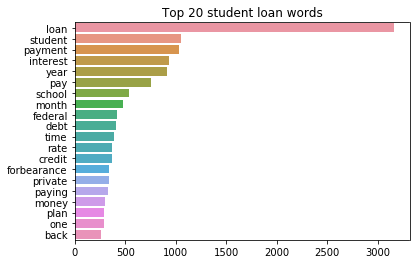

In [30]:
cvec_loan_20 = cvec_loan.sum().sort_values(ascending=False).head(20)

sns.barplot(y=cvec_loan_20.index.values, x = cvec_loan_20).set_title('Top 20 student loan words');

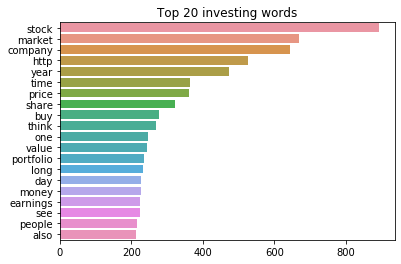

In [31]:
cvec_invest_20 = cvec_invest.sum().sort_values(ascending=False).head(20)

sns.barplot(y=cvec_invest_20.index.values, x = cvec_invest_20).set_title('Top 20 investing words');

In [36]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [33]:
age = [10,11,12,13,14,15]
ht = [180,181,182,183,184]

In [34]:
fig = plt.figure(figsize=(12, 10))

plt.scatter(age,ht)

TypeError: 'module' object is not callable